# CAR PREDICTION DAMAGE

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### DATA LOADING

In [6]:
dataset_path = "./dataset"
dataset=datasets.ImageFolder(root=dataset_path,transform=image_transforms)
len(dataset)

2300

In [7]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [34]:
class_names = dataset.classes
class_names 

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [9]:
num_classes= len(dataset.classes)
num_classes

6

In [10]:
train_size = int(0.75*len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [11]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [13]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [14]:
images[1].shape

torch.Size([3, 224, 224])

In [15]:
images[1].permute(1,2,0).shape # REORDERING THE SIZE BECAUSE whenplotting it requires the rgb at the end

torch.Size([224, 224, 3])

In [16]:
labels[1] 

tensor(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


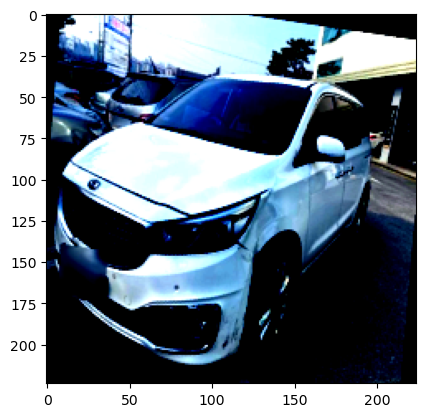

In [17]:
plt.imshow(images[1].permute(1,2,0))
plt.show()

###  MODEL 1 TRAINING MODEL CNN 

In [18]:
class CarClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network= nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1), #(16,224,224)
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #(16,112,112)
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),  
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #(32,56,56)
        nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),  
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2,padding=0), #(64,28,28)
        nn.Flatten(),
        nn.Linear(64*28*28,512),
        nn.ReLU(),
        nn.Linear(512,num_classes)   
        )
        
    def forward(self,x):
        x=self.network(x)
        return x

In [19]:
# # Instantiate the model, define loss function and optimizer
model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [20]:
def train_model(model,criterion,optimizer,epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num,(images,labels) in enumerate(train_loader):
            images,labels = images.to(device),labels.to(device)
            # forward pass
            outputs=model(images)
            loss=criterion(outputs,labels) #pred labels,true labels
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            
            #update weights
            optimizer.step()
            
             
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss=running_loss/len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")
    
    #validation
    model.eval()
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    torch.manual_seed(42)
    with torch.no_grad():
        for images,labels in val_loader:
            images,labels = images.to(device),labels.to(device)
            outputs=model(images)
            _, predicted=torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.numpy())    
            all_predicted.extend(predicted.numpy())
            
        print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
        
    end=time.time()
    print(f"Execution time{end-start} seconds")
    
    return all_labels,all_predicted

In [21]:
all_labels,all_predicted=train_model(model,criterion,optimizer,epochs=5)

Batch: 10, Epoch: 1, Loss: 1.78
Batch: 20, Epoch: 1, Loss: 1.67
Batch: 30, Epoch: 1, Loss: 1.63
Batch: 40, Epoch: 1, Loss: 1.57
Batch: 50, Epoch: 1, Loss: 1.36
Epoch [1/5], Avg Loss: 1.8386
Batch: 10, Epoch: 2, Loss: 1.56
Batch: 20, Epoch: 2, Loss: 1.27
Batch: 30, Epoch: 2, Loss: 1.45
Batch: 40, Epoch: 2, Loss: 1.19
Batch: 50, Epoch: 2, Loss: 0.99
Epoch [2/5], Avg Loss: 1.3003
Batch: 10, Epoch: 3, Loss: 1.03
Batch: 20, Epoch: 3, Loss: 0.99
Batch: 30, Epoch: 3, Loss: 1.32
Batch: 40, Epoch: 3, Loss: 1.27
Batch: 50, Epoch: 3, Loss: 0.89
Epoch [3/5], Avg Loss: 1.1521
Batch: 10, Epoch: 4, Loss: 1.21
Batch: 20, Epoch: 4, Loss: 1.06
Batch: 30, Epoch: 4, Loss: 0.87
Batch: 40, Epoch: 4, Loss: 0.87
Batch: 50, Epoch: 4, Loss: 0.91
Epoch [4/5], Avg Loss: 1.0199
Batch: 10, Epoch: 5, Loss: 1.11
Batch: 20, Epoch: 5, Loss: 1.00
Batch: 30, Epoch: 5, Loss: 1.02
Batch: 40, Epoch: 5, Loss: 0.94
Batch: 50, Epoch: 5, Loss: 0.91
Epoch [5/5], Avg Loss: 0.9761
*** Validation Accuracy: 56.00% ***
Execution time

# Model 2: CNN with Regularization

In [22]:
# you can see training loss is but the loss on unseen data which val data is high it is overfitting issue

class CarClassifierCNNWithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), # (16, 224, 224) 
            nn.BatchNorm2d(16), #nn.BatchNorm2d(16) normalizes the output,It improves training speed and stability by normalizing activations.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (16, 112, 112),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (32, 56, 56)           
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), # (64, 28, 28),
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),
            nn.Dropout(0.5), #Dropout forces the model to not rely too much on any single neuron, which helps prevent overfitting.
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.network(x)
        return x


In [23]:
model = CarClassifierCNNWithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #l2 reg

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=10)

Batch: 10, Epoch: 1, Loss: 15.10
Batch: 20, Epoch: 1, Loss: 5.55
Batch: 30, Epoch: 1, Loss: 2.98
Batch: 40, Epoch: 1, Loss: 1.53
Batch: 50, Epoch: 1, Loss: 1.34
Epoch [1/10], Avg Loss: 7.7439
Batch: 10, Epoch: 2, Loss: 1.33
Batch: 20, Epoch: 2, Loss: 1.47
Batch: 30, Epoch: 2, Loss: 1.72
Batch: 40, Epoch: 2, Loss: 1.42
Batch: 50, Epoch: 2, Loss: 1.30
Epoch [2/10], Avg Loss: 1.3134
Batch: 10, Epoch: 3, Loss: 1.17
Batch: 20, Epoch: 3, Loss: 1.41
Batch: 30, Epoch: 3, Loss: 1.20
Batch: 40, Epoch: 3, Loss: 1.10
Batch: 50, Epoch: 3, Loss: 1.09
Epoch [3/10], Avg Loss: 1.2312
Batch: 10, Epoch: 4, Loss: 0.97
Batch: 20, Epoch: 4, Loss: 1.06
Batch: 30, Epoch: 4, Loss: 1.22
Batch: 40, Epoch: 4, Loss: 1.37
Batch: 50, Epoch: 4, Loss: 1.23
Epoch [4/10], Avg Loss: 1.1990
Batch: 10, Epoch: 5, Loss: 1.24
Batch: 20, Epoch: 5, Loss: 1.27
Batch: 30, Epoch: 5, Loss: 1.17
Batch: 40, Epoch: 5, Loss: 1.37
Batch: 50, Epoch: 5, Loss: 1.16
Epoch [5/10], Avg Loss: 1.1760
Batch: 10, Epoch: 6, Loss: 1.25
Batch: 20, E

# Model 3: Transfer Learning with EfficientNet

In [24]:
model=models.efficientnet_b0(weights='DEFAULT')

# # Setting param.requires_grad = False effectively freezes the CNN layers of your pretrained EfficientNet model.

# You only train the new fully connected layer(s) that you added on top for your specific task (e.g., classification with 6 classes).

# This helps in leveraging the pretrained features while focusing training on the new task.


# Yes, the CNN part of EfficientNet (or any pretrained model) has already learned to recognize useful patterns,
# so you can freeze those layers and focus on training just the classifier for your new task.

# This allows you to take advantage of the learned features without the need to retrain the CNN layers, 
# which speeds up the training and reduces the computational cost.







In [25]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x           
        

In [26]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

# The filter(lambda p: p.requires_grad, model.parameters()) 
# ensures that only the trainable parameters (those with requires_grad=True) are passed to the optimizer,
# making the training process more efficient and targeting only the parts of the model that need to be updated.



# Why freeze some layers in transfer learning:
# Pre-trained layers already contain useful features: 
#     The convolutional layers of pre-trained models like EfficientNet, ResNet, etc., 
#     have already learned features like edges, textures, and basic shapes that are common across many types of images. 
#     These features are likely to be useful for your new task, so we don't need to retrain them from scratch.

# Only fine-tune the new layers: The new fully connected layers (classifier) 
# are where you want the model to learn the specific patterns and features related to your dataset (
# for example, identifying new classes). These layers are usually the ones that require training from scratch.

# The filter() ensures that the optimizer updates only the parameters of the layers that you want to train, 
# and leaves out the frozen layers (which you don't want to train).

Batch: 10, Epoch: 1, Loss: 1.66
Batch: 20, Epoch: 1, Loss: 1.56
Batch: 30, Epoch: 1, Loss: 1.50
Batch: 40, Epoch: 1, Loss: 1.42
Batch: 50, Epoch: 1, Loss: 1.22
Epoch [1/10], Avg Loss: 1.4998
Batch: 10, Epoch: 2, Loss: 1.28
Batch: 20, Epoch: 2, Loss: 1.07
Batch: 30, Epoch: 2, Loss: 1.13
Batch: 40, Epoch: 2, Loss: 1.21
Batch: 50, Epoch: 2, Loss: 1.08
Epoch [2/10], Avg Loss: 1.1526
Batch: 10, Epoch: 3, Loss: 0.87
Batch: 20, Epoch: 3, Loss: 1.10
Batch: 30, Epoch: 3, Loss: 1.05
Batch: 40, Epoch: 3, Loss: 1.03
Batch: 50, Epoch: 3, Loss: 1.08
Epoch [3/10], Avg Loss: 1.0404
Batch: 10, Epoch: 4, Loss: 1.10
Batch: 20, Epoch: 4, Loss: 0.95
Batch: 30, Epoch: 4, Loss: 1.03
Batch: 40, Epoch: 4, Loss: 1.13
Batch: 50, Epoch: 4, Loss: 0.64
Epoch [4/10], Avg Loss: 0.9599
Batch: 10, Epoch: 5, Loss: 1.06
Batch: 20, Epoch: 5, Loss: 0.88
Batch: 30, Epoch: 5, Loss: 1.17
Batch: 40, Epoch: 5, Loss: 0.96
Batch: 50, Epoch: 5, Loss: 1.28
Epoch [5/10], Avg Loss: 0.9245
Batch: 10, Epoch: 6, Loss: 0.96
Batch: 20, Ep

# Model 4: Transfer Learning with ResNet

In [27]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x
    
    
# Unfreezing layer4 and replacing the final fc layer allows the model to adapt high-level features (e.g., car shape, details) 
# to your specific task. Layer4 captures complex patterns, which are fine-tuned to fit car classification. 
# The new fc layer uses these high-level features to make final predictions for your custom classes, 
# leveraging the learned patterns.


# If you freeze layer4, the model will only rely on the general features learned in the earlier layers (like edges and textures).
# This could lead to:

# Reduced accuracy: It won't be able to learn the high-level, task-specific features that are important for distinguishing car 
# types.

# Poor task adaptation: The model won't be able to fine-tune the more complex, relevant features needed for better car 
# classification.

In [28]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 0.99
Batch: 20, Epoch: 1, Loss: 0.91
Batch: 30, Epoch: 1, Loss: 0.57
Batch: 40, Epoch: 1, Loss: 0.73
Batch: 50, Epoch: 1, Loss: 0.57
Epoch [1/5], Avg Loss: 0.8846
Batch: 10, Epoch: 2, Loss: 0.54
Batch: 20, Epoch: 2, Loss: 0.27
Batch: 30, Epoch: 2, Loss: 0.47
Batch: 40, Epoch: 2, Loss: 0.46
Batch: 50, Epoch: 2, Loss: 0.30
Epoch [2/5], Avg Loss: 0.4693
Batch: 10, Epoch: 3, Loss: 0.35
Batch: 20, Epoch: 3, Loss: 0.39
Batch: 30, Epoch: 3, Loss: 0.30
Batch: 40, Epoch: 3, Loss: 0.38
Batch: 50, Epoch: 3, Loss: 0.75
Epoch [3/5], Avg Loss: 0.3584
Batch: 10, Epoch: 4, Loss: 0.30
Batch: 20, Epoch: 4, Loss: 0.29
Batch: 30, Epoch: 4, Loss: 0.29
Batch: 40, Epoch: 4, Loss: 0.19
Batch: 50, Epoch: 4, Loss: 0.39
Epoch [4/5], Avg Loss: 0.2818
Batch: 10, Epoch: 5, Loss: 0.10
Batch: 20, Epoch: 5, Loss: 0.12
Batch: 30, Epoch: 5, Loss: 0.27
Batch: 40, Epoch: 5, Loss: 0.24
Batch: 50, Epoch: 5, Loss: 0.27
Epoch [5/5], Avg Loss: 0.1995
*** Validation Accuracy: 81.91% ***
Execution time

### I ran hyperparameter tunning in another notebook and figured that the best parameters for resnet models are (1) Dropout rate = 0.2 (2) Learning Rate = 0.005
### So now let's train the model once again with these best parameters

In [29]:
model = CarClassifierResNet(num_classes=num_classes, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

labels, predictions = train_model(model, criterion, optimizer, epochs=4)

Batch: 10, Epoch: 1, Loss: 0.85
Batch: 20, Epoch: 1, Loss: 1.07
Batch: 30, Epoch: 1, Loss: 0.59
Batch: 40, Epoch: 1, Loss: 0.92
Batch: 50, Epoch: 1, Loss: 0.50
Epoch [1/4], Avg Loss: 0.8786
Batch: 10, Epoch: 2, Loss: 0.51
Batch: 20, Epoch: 2, Loss: 0.39
Batch: 30, Epoch: 2, Loss: 0.59
Batch: 40, Epoch: 2, Loss: 0.47
Batch: 50, Epoch: 2, Loss: 0.31
Epoch [2/4], Avg Loss: 0.4863
Batch: 10, Epoch: 3, Loss: 0.47
Batch: 20, Epoch: 3, Loss: 0.68
Batch: 30, Epoch: 3, Loss: 0.38
Batch: 40, Epoch: 3, Loss: 0.86
Batch: 50, Epoch: 3, Loss: 0.54
Epoch [3/4], Avg Loss: 0.3962
Batch: 10, Epoch: 4, Loss: 0.51
Batch: 20, Epoch: 4, Loss: 0.31
Batch: 30, Epoch: 4, Loss: 0.22
Batch: 40, Epoch: 4, Loss: 0.30
Batch: 50, Epoch: 4, Loss: 0.28
Epoch [4/4], Avg Loss: 0.3098
*** Validation Accuracy: 79.48% ***
Execution time546.3737571239471 seconds


#taking very long to un around 15 to 17 minutes so we can use hyper tuning code in other notebook and confusion matrix in other notebook and save the model

## Model Evaluation using Confusion Matrix and Classification Report

In [30]:
from sklearn.metrics import classification_report

report = classification_report(labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       126
           1       0.69      0.85      0.77        88
           2       0.94      0.92      0.93       119
           3       0.72      0.87      0.78        82
           4       0.73      0.41      0.53        73
           5       0.73      0.87      0.80        87

    accuracy                           0.79       575
   macro avg       0.79      0.78      0.77       575
weighted avg       0.80      0.79      0.79       575



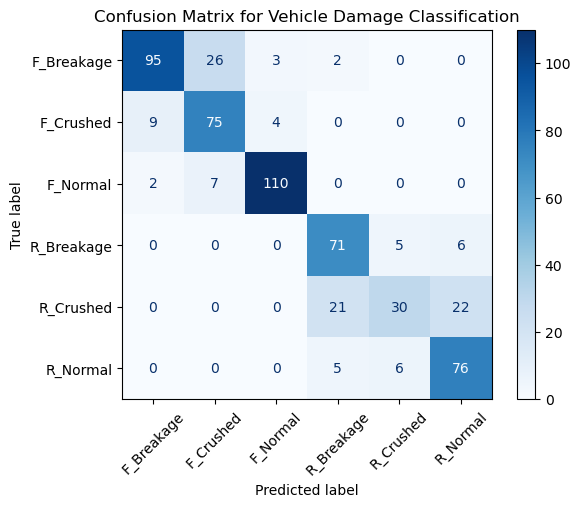

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

conf_matrix = confusion_matrix(labels, predictions, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Vehicle Damage Classification")
plt.show()

## Save the Model

In [36]:
torch.save(model.state_dict(), 'best_model.pth')

In [38]:
import gradio as gr
from PIL import Image

# Load the trained model (replace 'model.pth' if needed)
model = CarClassifierCNN(num_classes)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

# Prediction function for Gradio
def predict_damage(img):
    img_tensor = image_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
        prediction = class_names[predicted.item()]
    return f"Predicted Damage: {prediction}"

# Gradio interface
gr.Interface(
    fn=predict_damage,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Vehicle Damage Detection",
    description="Upload an image to detect the type of damage"
).launch()


RuntimeError: Error(s) in loading state_dict for CarClassifierCNN:
	Missing key(s) in state_dict: "network.0.weight", "network.0.bias", "network.3.weight", "network.3.bias", "network.6.weight", "network.6.bias", "network.10.weight", "network.10.bias", "network.12.weight", "network.12.bias". 
	Unexpected key(s) in state_dict: "model.conv1.weight", "model.bn1.weight", "model.bn1.bias", "model.bn1.running_mean", "model.bn1.running_var", "model.bn1.num_batches_tracked", "model.layer1.0.conv1.weight", "model.layer1.0.bn1.weight", "model.layer1.0.bn1.bias", "model.layer1.0.bn1.running_mean", "model.layer1.0.bn1.running_var", "model.layer1.0.bn1.num_batches_tracked", "model.layer1.0.conv2.weight", "model.layer1.0.bn2.weight", "model.layer1.0.bn2.bias", "model.layer1.0.bn2.running_mean", "model.layer1.0.bn2.running_var", "model.layer1.0.bn2.num_batches_tracked", "model.layer1.0.conv3.weight", "model.layer1.0.bn3.weight", "model.layer1.0.bn3.bias", "model.layer1.0.bn3.running_mean", "model.layer1.0.bn3.running_var", "model.layer1.0.bn3.num_batches_tracked", "model.layer1.0.downsample.0.weight", "model.layer1.0.downsample.1.weight", "model.layer1.0.downsample.1.bias", "model.layer1.0.downsample.1.running_mean", "model.layer1.0.downsample.1.running_var", "model.layer1.0.downsample.1.num_batches_tracked", "model.layer1.1.conv1.weight", "model.layer1.1.bn1.weight", "model.layer1.1.bn1.bias", "model.layer1.1.bn1.running_mean", "model.layer1.1.bn1.running_var", "model.layer1.1.bn1.num_batches_tracked", "model.layer1.1.conv2.weight", "model.layer1.1.bn2.weight", "model.layer1.1.bn2.bias", "model.layer1.1.bn2.running_mean", "model.layer1.1.bn2.running_var", "model.layer1.1.bn2.num_batches_tracked", "model.layer1.1.conv3.weight", "model.layer1.1.bn3.weight", "model.layer1.1.bn3.bias", "model.layer1.1.bn3.running_mean", "model.layer1.1.bn3.running_var", "model.layer1.1.bn3.num_batches_tracked", "model.layer1.2.conv1.weight", "model.layer1.2.bn1.weight", "model.layer1.2.bn1.bias", "model.layer1.2.bn1.running_mean", "model.layer1.2.bn1.running_var", "model.layer1.2.bn1.num_batches_tracked", "model.layer1.2.conv2.weight", "model.layer1.2.bn2.weight", "model.layer1.2.bn2.bias", "model.layer1.2.bn2.running_mean", "model.layer1.2.bn2.running_var", "model.layer1.2.bn2.num_batches_tracked", "model.layer1.2.conv3.weight", "model.layer1.2.bn3.weight", "model.layer1.2.bn3.bias", "model.layer1.2.bn3.running_mean", "model.layer1.2.bn3.running_var", "model.layer1.2.bn3.num_batches_tracked", "model.layer2.0.conv1.weight", "model.layer2.0.bn1.weight", "model.layer2.0.bn1.bias", "model.layer2.0.bn1.running_mean", "model.layer2.0.bn1.running_var", "model.layer2.0.bn1.num_batches_tracked", "model.layer2.0.conv2.weight", "model.layer2.0.bn2.weight", "model.layer2.0.bn2.bias", "model.layer2.0.bn2.running_mean", "model.layer2.0.bn2.running_var", "model.layer2.0.bn2.num_batches_tracked", "model.layer2.0.conv3.weight", "model.layer2.0.bn3.weight", "model.layer2.0.bn3.bias", "model.layer2.0.bn3.running_mean", "model.layer2.0.bn3.running_var", "model.layer2.0.bn3.num_batches_tracked", "model.layer2.0.downsample.0.weight", "model.layer2.0.downsample.1.weight", "model.layer2.0.downsample.1.bias", "model.layer2.0.downsample.1.running_mean", "model.layer2.0.downsample.1.running_var", "model.layer2.0.downsample.1.num_batches_tracked", "model.layer2.1.conv1.weight", "model.layer2.1.bn1.weight", "model.layer2.1.bn1.bias", "model.layer2.1.bn1.running_mean", "model.layer2.1.bn1.running_var", "model.layer2.1.bn1.num_batches_tracked", "model.layer2.1.conv2.weight", "model.layer2.1.bn2.weight", "model.layer2.1.bn2.bias", "model.layer2.1.bn2.running_mean", "model.layer2.1.bn2.running_var", "model.layer2.1.bn2.num_batches_tracked", "model.layer2.1.conv3.weight", "model.layer2.1.bn3.weight", "model.layer2.1.bn3.bias", "model.layer2.1.bn3.running_mean", "model.layer2.1.bn3.running_var", "model.layer2.1.bn3.num_batches_tracked", "model.layer2.2.conv1.weight", "model.layer2.2.bn1.weight", "model.layer2.2.bn1.bias", "model.layer2.2.bn1.running_mean", "model.layer2.2.bn1.running_var", "model.layer2.2.bn1.num_batches_tracked", "model.layer2.2.conv2.weight", "model.layer2.2.bn2.weight", "model.layer2.2.bn2.bias", "model.layer2.2.bn2.running_mean", "model.layer2.2.bn2.running_var", "model.layer2.2.bn2.num_batches_tracked", "model.layer2.2.conv3.weight", "model.layer2.2.bn3.weight", "model.layer2.2.bn3.bias", "model.layer2.2.bn3.running_mean", "model.layer2.2.bn3.running_var", "model.layer2.2.bn3.num_batches_tracked", "model.layer2.3.conv1.weight", "model.layer2.3.bn1.weight", "model.layer2.3.bn1.bias", "model.layer2.3.bn1.running_mean", "model.layer2.3.bn1.running_var", "model.layer2.3.bn1.num_batches_tracked", "model.layer2.3.conv2.weight", "model.layer2.3.bn2.weight", "model.layer2.3.bn2.bias", "model.layer2.3.bn2.running_mean", "model.layer2.3.bn2.running_var", "model.layer2.3.bn2.num_batches_tracked", "model.layer2.3.conv3.weight", "model.layer2.3.bn3.weight", "model.layer2.3.bn3.bias", "model.layer2.3.bn3.running_mean", "model.layer2.3.bn3.running_var", "model.layer2.3.bn3.num_batches_tracked", "model.layer3.0.conv1.weight", "model.layer3.0.bn1.weight", "model.layer3.0.bn1.bias", "model.layer3.0.bn1.running_mean", "model.layer3.0.bn1.running_var", "model.layer3.0.bn1.num_batches_tracked", "model.layer3.0.conv2.weight", "model.layer3.0.bn2.weight", "model.layer3.0.bn2.bias", "model.layer3.0.bn2.running_mean", "model.layer3.0.bn2.running_var", "model.layer3.0.bn2.num_batches_tracked", "model.layer3.0.conv3.weight", "model.layer3.0.bn3.weight", "model.layer3.0.bn3.bias", "model.layer3.0.bn3.running_mean", "model.layer3.0.bn3.running_var", "model.layer3.0.bn3.num_batches_tracked", "model.layer3.0.downsample.0.weight", "model.layer3.0.downsample.1.weight", "model.layer3.0.downsample.1.bias", "model.layer3.0.downsample.1.running_mean", "model.layer3.0.downsample.1.running_var", "model.layer3.0.downsample.1.num_batches_tracked", "model.layer3.1.conv1.weight", "model.layer3.1.bn1.weight", "model.layer3.1.bn1.bias", "model.layer3.1.bn1.running_mean", "model.layer3.1.bn1.running_var", "model.layer3.1.bn1.num_batches_tracked", "model.layer3.1.conv2.weight", "model.layer3.1.bn2.weight", "model.layer3.1.bn2.bias", "model.layer3.1.bn2.running_mean", "model.layer3.1.bn2.running_var", "model.layer3.1.bn2.num_batches_tracked", "model.layer3.1.conv3.weight", "model.layer3.1.bn3.weight", "model.layer3.1.bn3.bias", "model.layer3.1.bn3.running_mean", "model.layer3.1.bn3.running_var", "model.layer3.1.bn3.num_batches_tracked", "model.layer3.2.conv1.weight", "model.layer3.2.bn1.weight", "model.layer3.2.bn1.bias", "model.layer3.2.bn1.running_mean", "model.layer3.2.bn1.running_var", "model.layer3.2.bn1.num_batches_tracked", "model.layer3.2.conv2.weight", "model.layer3.2.bn2.weight", "model.layer3.2.bn2.bias", "model.layer3.2.bn2.running_mean", "model.layer3.2.bn2.running_var", "model.layer3.2.bn2.num_batches_tracked", "model.layer3.2.conv3.weight", "model.layer3.2.bn3.weight", "model.layer3.2.bn3.bias", "model.layer3.2.bn3.running_mean", "model.layer3.2.bn3.running_var", "model.layer3.2.bn3.num_batches_tracked", "model.layer3.3.conv1.weight", "model.layer3.3.bn1.weight", "model.layer3.3.bn1.bias", "model.layer3.3.bn1.running_mean", "model.layer3.3.bn1.running_var", "model.layer3.3.bn1.num_batches_tracked", "model.layer3.3.conv2.weight", "model.layer3.3.bn2.weight", "model.layer3.3.bn2.bias", "model.layer3.3.bn2.running_mean", "model.layer3.3.bn2.running_var", "model.layer3.3.bn2.num_batches_tracked", "model.layer3.3.conv3.weight", "model.layer3.3.bn3.weight", "model.layer3.3.bn3.bias", "model.layer3.3.bn3.running_mean", "model.layer3.3.bn3.running_var", "model.layer3.3.bn3.num_batches_tracked", "model.layer3.4.conv1.weight", "model.layer3.4.bn1.weight", "model.layer3.4.bn1.bias", "model.layer3.4.bn1.running_mean", "model.layer3.4.bn1.running_var", "model.layer3.4.bn1.num_batches_tracked", "model.layer3.4.conv2.weight", "model.layer3.4.bn2.weight", "model.layer3.4.bn2.bias", "model.layer3.4.bn2.running_mean", "model.layer3.4.bn2.running_var", "model.layer3.4.bn2.num_batches_tracked", "model.layer3.4.conv3.weight", "model.layer3.4.bn3.weight", "model.layer3.4.bn3.bias", "model.layer3.4.bn3.running_mean", "model.layer3.4.bn3.running_var", "model.layer3.4.bn3.num_batches_tracked", "model.layer3.5.conv1.weight", "model.layer3.5.bn1.weight", "model.layer3.5.bn1.bias", "model.layer3.5.bn1.running_mean", "model.layer3.5.bn1.running_var", "model.layer3.5.bn1.num_batches_tracked", "model.layer3.5.conv2.weight", "model.layer3.5.bn2.weight", "model.layer3.5.bn2.bias", "model.layer3.5.bn2.running_mean", "model.layer3.5.bn2.running_var", "model.layer3.5.bn2.num_batches_tracked", "model.layer3.5.conv3.weight", "model.layer3.5.bn3.weight", "model.layer3.5.bn3.bias", "model.layer3.5.bn3.running_mean", "model.layer3.5.bn3.running_var", "model.layer3.5.bn3.num_batches_tracked", "model.layer4.0.conv1.weight", "model.layer4.0.bn1.weight", "model.layer4.0.bn1.bias", "model.layer4.0.bn1.running_mean", "model.layer4.0.bn1.running_var", "model.layer4.0.bn1.num_batches_tracked", "model.layer4.0.conv2.weight", "model.layer4.0.bn2.weight", "model.layer4.0.bn2.bias", "model.layer4.0.bn2.running_mean", "model.layer4.0.bn2.running_var", "model.layer4.0.bn2.num_batches_tracked", "model.layer4.0.conv3.weight", "model.layer4.0.bn3.weight", "model.layer4.0.bn3.bias", "model.layer4.0.bn3.running_mean", "model.layer4.0.bn3.running_var", "model.layer4.0.bn3.num_batches_tracked", "model.layer4.0.downsample.0.weight", "model.layer4.0.downsample.1.weight", "model.layer4.0.downsample.1.bias", "model.layer4.0.downsample.1.running_mean", "model.layer4.0.downsample.1.running_var", "model.layer4.0.downsample.1.num_batches_tracked", "model.layer4.1.conv1.weight", "model.layer4.1.bn1.weight", "model.layer4.1.bn1.bias", "model.layer4.1.bn1.running_mean", "model.layer4.1.bn1.running_var", "model.layer4.1.bn1.num_batches_tracked", "model.layer4.1.conv2.weight", "model.layer4.1.bn2.weight", "model.layer4.1.bn2.bias", "model.layer4.1.bn2.running_mean", "model.layer4.1.bn2.running_var", "model.layer4.1.bn2.num_batches_tracked", "model.layer4.1.conv3.weight", "model.layer4.1.bn3.weight", "model.layer4.1.bn3.bias", "model.layer4.1.bn3.running_mean", "model.layer4.1.bn3.running_var", "model.layer4.1.bn3.num_batches_tracked", "model.layer4.2.conv1.weight", "model.layer4.2.bn1.weight", "model.layer4.2.bn1.bias", "model.layer4.2.bn1.running_mean", "model.layer4.2.bn1.running_var", "model.layer4.2.bn1.num_batches_tracked", "model.layer4.2.conv2.weight", "model.layer4.2.bn2.weight", "model.layer4.2.bn2.bias", "model.layer4.2.bn2.running_mean", "model.layer4.2.bn2.running_var", "model.layer4.2.bn2.num_batches_tracked", "model.layer4.2.conv3.weight", "model.layer4.2.bn3.weight", "model.layer4.2.bn3.bias", "model.layer4.2.bn3.running_mean", "model.layer4.2.bn3.running_var", "model.layer4.2.bn3.num_batches_tracked", "model.fc.1.weight", "model.fc.1.bias". 